<a href="https://colab.research.google.com/github/Chubbyman2/Medical_Image_Classifier/blob/main/Medical_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WARNING: Images shown are quite graphic. Viewer disrection is advised.**

In [16]:
import os
import keras
import numpy as np
from keras import optimizers, models, layers
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, get_file

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/My Drive/kvasir-dataset-v2.zip"

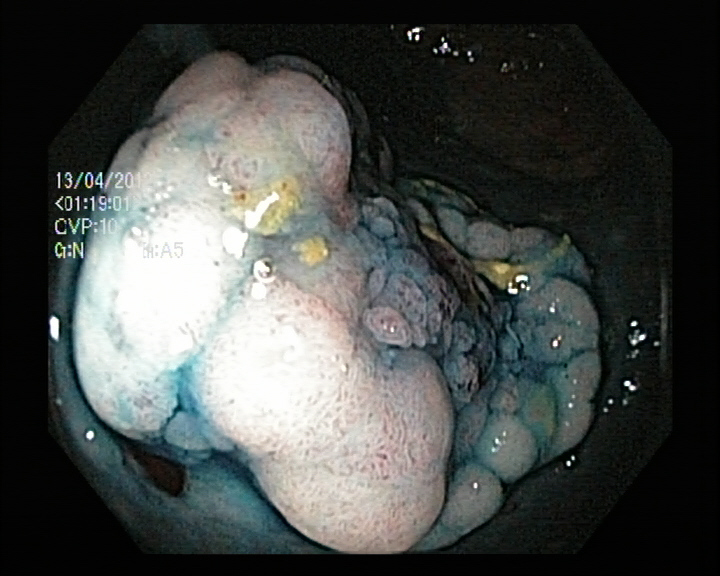

In [12]:
# Image sample from dataset
from IPython.display import Image

img = Image("kvasir-dataset-v2/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg")
img

In [13]:
# Create a dictionary of the classes and a reverse dictionary
classes = dict()
reverse_classes = dict()
count = 0
for folder in os.listdir("kvasir-dataset-v2"):
    classes[folder] = count
    reverse_classes[count] = img
    count = count + 1

classes

{'dyed-lifted-polyps': 5,
 'dyed-resection-margins': 3,
 'esophagitis': 2,
 'normal-cecum': 7,
 'normal-pylorus': 6,
 'normal-z-line': 0,
 'polyps': 4,
 'ulcerative-colitis': 1}

In [37]:
from PIL import Image

def get_data(stop):
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for class_folder in os.listdir("kvasir-dataset-v2/"):
      print(f"Processing {class_folder}...")
      count = 0
      count2 = 0
      for img in os.listdir(f"kvasir-dataset-v2/{class_folder}/"):
        # For training dataset
        if count < stop:
          image = Image.open(f"kvasir-dataset-v2/{class_folder}/{img}")
          image = image.resize((224, 224))
          arr = np.array(image)
          x_train.append(arr)
          count += 1

        # For validation dataset
        else:
          image = Image.open(f"kvasir-dataset-v2/{class_folder}/{img}")
          image = image.resize((224, 224))
          arr = np.array(image)
          x_test.append(arr)
          count2 += 1
          
      y_values = np.full((count, 1), classes[class_folder])
      y_train.append(y_values)
      y_values2 = np.full((count2, 1), classes[class_folder])
      y_test.append(y_values2)
         
    return x_train, y_train, x_test, y_test

In [39]:
# Normalizes data, converts to numpy arrays, shuffles it
import random
def process_data(x_data, y_data):
    x_data = np.array(x_data, dtype = "float32")
    x_data = x_data.reshape((len(x_data), 224, 224, 3))
    x_data /= 255
    
    y_data = np.array(y_data)
    y_data = y_data.reshape(len(x_data), 1)
    y_data = to_categorical(y_data)
    return x_data, y_data

In [40]:
# Split dataset 80/20
X_train, y_train, X_test, y_test = get_data(800)

# Process data, convert to numpy arrays
X_train, y_train = process_data(X_train, y_train)
X_test, y_test = process_data(X_test, y_test)

Processing normal-z-line...
Processing ulcerative-colitis...
Processing esophagitis...
Processing dyed-resection-margins...
Processing polyps...
Processing dyed-lifted-polyps...
Processing normal-pylorus...
Processing normal-cecum...


In [41]:
BATCH_SIZE = 64

# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=[0.95, 1.05],
    horizontal_flip=True)

datagen.fit(X_train)

In [42]:
# Input is 224x224 colour images
model = models.Sequential([
    Conv2D(32, (5, 5), strides=(2, 2), activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPool2D((2, 2)),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation="relu"),
    Dense(8, activation="softmax") 
])

In [43]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [44]:
# Early stopping
early_stopping = EarlyStopping(patience=3)
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), steps_per_epoch = len(X_train)/BATCH_SIZE, epochs=20, callbacks=[early_stopping], validation_data=(X_test, y_test))

Epoch 1/20
100/100 [==============================] - 68s 679ms/step - loss: 1.6106 - accuracy: 0.3745 - val_loss: 1.8100 - val_accuracy: 0.2450
Epoch 2/20
100/100 [==============================] - 69s 693ms/step - loss: 1.1327 - accuracy: 0.5066 - val_loss: 1.3217 - val_accuracy: 0.5200
Epoch 3/20
100/100 [==============================] - 69s 693ms/step - loss: 1.0021 - accuracy: 0.5423 - val_loss: 1.3234 - val_accuracy: 0.4731
Epoch 4/20
100/100 [==============================] - 69s 694ms/step - loss: 0.9569 - accuracy: 0.5683 - val_loss: 1.3212 - val_accuracy: 0.4181
Epoch 5/20
100/100 [==============================] - 69s 689ms/step - loss: 0.9407 - accuracy: 0.5780 - val_loss: 1.2221 - val_accuracy: 0.4994
Epoch 6/20
100/100 [==============================] - 69s 690ms/step - loss: 0.8824 - accuracy: 0.5972 - val_loss: 1.2985 - val_accuracy: 0.5038
Epoch 7/20
100/100 [==============================] - 70s 704ms/step - loss: 0.8359 - accuracy: 0.6170 - val_loss: 1.2912 - val_ac

In [45]:
model.save("kvasir_classifier.h5")

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

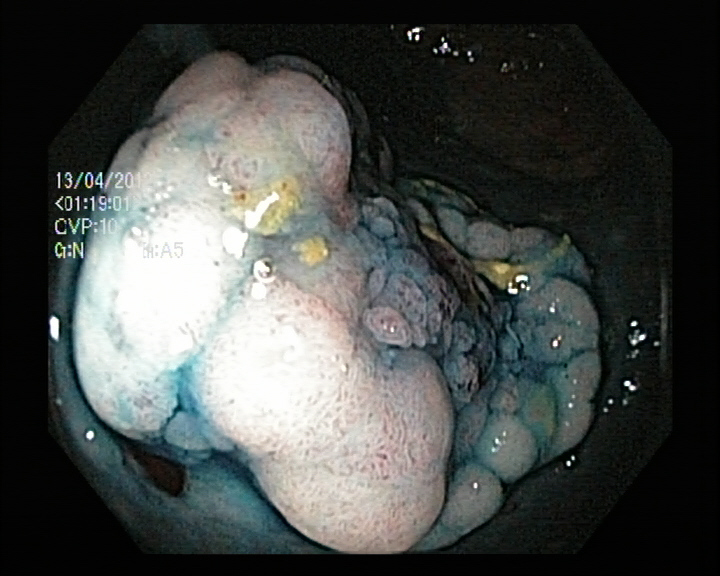

In [47]:
# The model predicted the sample image accurately
image = Image.open(f"kvasir-dataset-v2/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg")
image = image.resize((224, 224))
arr = np.array(image)
x_data = [arr]
x_data = np.array(x_data, dtype = "float32")
x_data = x_data.reshape((len(x_data), 224, 224, 3))
x_data /= 255

pred_array = model.predict(x_data)
result = reverse_classes[np.argmax(pred_array)]
result

**Plot Training and Validation Graphs**

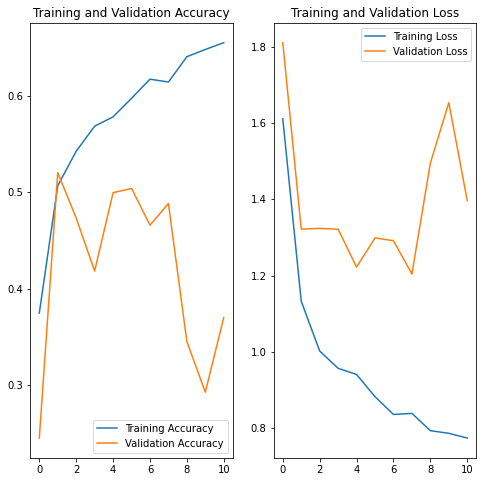

In [49]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()